In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd #data processing
import numpy as np #array processing 
import matplotlib.pyplot as plt #plotting

from sklearn.preprocessing import LabelEncoder #multiclass encoding
from sklearn.model_selection import train_test_split 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.7.0


In [ ]:
!pip install keras-tuner --upgrade

In [43]:
data = pd.read_csv('/content/drive/MyDrive/preProcessed_data.csv')

In [44]:
data.shape

(1098208, 6)

In [45]:
data.head()

,personId,class,timestamp,x,y,z
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


In [46]:
data.dtypes

personId       int64
class         object
timestamp      int64
x            float64
y            float64
z            float64
dtype: object

In [47]:
data.sort_values(['personId','timestamp'],inplace=True)

In [48]:
data['class'].value_counts().min()

48395

In [52]:
# data.groupby('personId').size()

In [53]:
balanced_data = pd.DataFrame()
for i in data['class'].unique():
  balanced_data=balanced_data.append(data.iloc[data[data['class']==i].index[:48395]].copy())

In [54]:
balanced_data['class'].value_counts()

Sitting       48395
Walking       48395
Downstairs    48395
Standing      48395
Upstairs      48395
Jogging       48395
Name: class, dtype: int64

In [55]:
encoder = LabelEncoder()
balanced_data['label'] = encoder.fit_transform(balanced_data['class'])
balanced_data.head()

,personId,class,timestamp,x,y,z,label
0,1,Walking,4991922345000,0.69,10.80,-2.03,5
1,1,Walking,4991972333000,6.85,7.44,-0.50,5
2,1,Walking,4992022351000,0.93,5.63,-0.50,5
3,1,Walking,4992072339000,-2.11,5.01,-0.69,5
4,1,Walking,4992122358000,-4.59,4.29,-1.95,5


In [57]:
encoder.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [61]:
def time_segments(data, size, stride,p):
    segment = []
    labels = []

    # make segments of t seconds block with stride
    for i in range(0, len(data) - size, stride):
        if data['personId'].iloc[i:i+size].nunique()>1:
          continue     
        segment.append([data['x'].iloc[i:i+size], data['y'].iloc[i:i+size], data['z'].iloc[i:i+size]])
        # Retrieve the most often used label in this segment
        labels.append(data['label'].iloc[i:i+size].mode()[0])

    # Bring the segments into a better shape
    segment = np.asarray(segment).reshape(-1, size, p)
    labels = np.asarray(labels)

    return segment, labels

In [62]:
reading_per_second = 20
size = reading_per_second*10 # 200 records for t seconds 
stride = reading_per_second*2 # 80 records jump

print(size,stride)

200 40


In [69]:
X, y = time_segments(balanced_data, size, stride,p=3)
X.shape, y.shape

((6832, 200, 3), (6832,))

In [10]:
data.drop(['personId','timestamp'],axis=1,inplace=True)

In [67]:
balanced_data.shape[0] /stride

7259.25

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) 
print(X_train.shape, X_val.shape,X_test.shape)

(4645, 200, 3) (1162, 200, 3) (1025, 200, 3)


In [86]:
X_train = X_train.reshape(X_train.shape[0], size, 3, 1)
X_test = X_test.reshape(X_test.shape[0], size, 3, 1)
X_val = X_val.reshape(X_val.shape[0], size, 3, 1)

Required functions

In [87]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

## **Convolution 2d**

In [88]:
X_train.shape

(4645, 200, 3, 1)

In [89]:
X_train[0].shape

(200, 3, 1)

**filters = 16,32 -> epoch 20** \\
loss: 0.4292 - accuracy: 0.7974 - val_loss: 0.3976 - val_accuracy: 0.8512 \\

In [90]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [91]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 199, 2, 32)        160       
                                                                 
 dropout_8 (Dropout)         (None, 199, 2, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 198, 1, 64)        8256      
                                                                 
 dropout_9 (Dropout)         (None, 198, 1, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 12672)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                811072    
                                                                 
 dropout_10 (Dropout)        (None, 64)               

In [93]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
146/146 [==============================] - 6s 35ms/step - loss: 1.0742 - accuracy: 0.5709 - val_loss: 0.6790 - val_accuracy: 0.7346
Epoch 2/10
146/146 [==============================] - 5s 35ms/step - loss: 0.7861 - accuracy: 0.6652 - val_loss: 0.5551 - val_accuracy: 0.7493
Epoch 3/10
146/146 [==============================] - 5s 34ms/step - loss: 0.6440 - accuracy: 0.7085 - val_loss: 0.5024 - val_accuracy: 0.7795
Epoch 4/10
146/146 [==============================] - 5s 34ms/step - loss: 0.5471 - accuracy: 0.7455 - val_loss: 0.4387 - val_accuracy: 0.8263
Epoch 5/10
146/146 [==============================] - 5s 35ms/step - loss: 0.5115 - accuracy: 0.7651 - val_loss: 0.3717 - val_accuracy: 0.8459
Epoch 6/10
146/146 [==============================] - 5s 34ms/step - loss: 0.4557 - accuracy: 0.7927 - val_loss: 0.3868 - val_accuracy: 0.8429
Epoch 7/10
146/146 [==============================] - 5s 34ms/step - loss: 0.4053 - accuracy: 0.8161 - val_loss: 0.3143 - val_accuracy: 0.8576

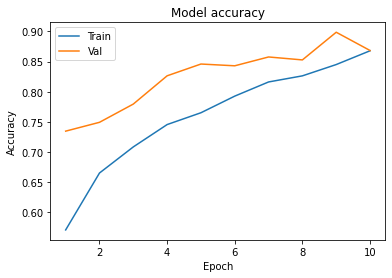

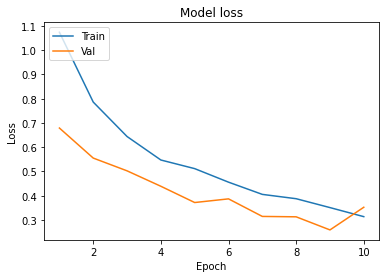

In [94]:
plot_learningCurve(history, 10)

We can consider more epochs

In [ ]:
history = model.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test), verbose=1)

In [ ]:
plot_learningCurve(history, 20)

Tune CNN Models

In [36]:
def build_model(hp):
  model = keras.Sequential([
  keras.layers.Conv2D(
      #adding filter 
      filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
      # adding filter size or kernel size
      kernel_size=hp.Choice('conv_1_kernel', values = [1,2]),
      #activation function
      activation='relu',
      input_shape=(200,3,1)),
  Dropout(hp.Choice('rate', values=[0.1, 0.2])),
  keras.layers.Conv2D(
      #adding filter 
      filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
      # adding filter size or kernel size
      kernel_size=hp.Choice('conv_1_kernel', values = [1,2]),
      #activation function
      activation='relu'),
  Dropout(hp.Choice('rate', values=[0.2,0.3,0.4])),
  Flatten(),
  keras.layers.Dense(hp.Choice('units', [32,64,128]), activation='relu'),
  Dropout(0.5),
  keras.layers.Dense(6, activation='softmax')]
  )
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [37]:
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_loss',
                    max_trials = 5,overwrite = True)
# search best parameter
tuner.search(X_train,y_train,epochs=3,validation_data=(X_val,y_val))

Trial 5 Complete [00h 00m 41s]
val_loss: 0.9387630224227905

Best val_loss So Far: 0.47428029775619507
Total elapsed time: 00h 02m 47s
INFO:tensorflow:Oracle triggered exit


In [250]:
keras.backend.clear_session()

In [38]:
model=tuner.get_best_models(num_models=1)[0]
#summary of best model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 2, 64)        320       
                                                                 
 dropout (Dropout)           (None, 199, 2, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 198, 1, 64)        16448     
                                                                 
 dropout_1 (Dropout)         (None, 198, 1, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 32)                405536    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [40]:
history = model.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test), verbose=1)

Epoch 1/20
155/155 [==============================] - 7s 45ms/step - loss: 0.5410 - accuracy: 0.7472 - val_loss: 0.3410 - val_accuracy: 0.8549
Epoch 2/20
155/155 [==============================] - 7s 45ms/step - loss: 0.5337 - accuracy: 0.7630 - val_loss: 0.3539 - val_accuracy: 0.8283
Epoch 3/20
155/155 [==============================] - 7s 45ms/step - loss: 0.4990 - accuracy: 0.7786 - val_loss: 0.2822 - val_accuracy: 0.8742
Epoch 4/20
155/155 [==============================] - 7s 45ms/step - loss: 0.4870 - accuracy: 0.7778 - val_loss: 0.3060 - val_accuracy: 0.8577
Epoch 5/20
155/155 [==============================] - 7s 45ms/step - loss: 0.4794 - accuracy: 0.7853 - val_loss: 0.2765 - val_accuracy: 0.8659
Epoch 6/20
155/155 [==============================] - 7s 45ms/step - loss: 0.4548 - accuracy: 0.7914 - val_loss: 0.2796 - val_accuracy: 0.8843
Epoch 7/20
155/155 [==============================] - 7s 45ms/step - loss: 0.4707 - accuracy: 0.7863 - val_loss: 0.2810 - val_accuracy: 0.8797

Evaluation 
1. Metrics
2. Confusion Matrix

In [ ]:
loss, acc = model.evaluate(X, y, verbose=0)

In [ ]:
# logger.debug(f"accuracy={accuracy_score(y_test, test_pred)}")
# logger.debug(f"precision={precision_score(y_test, test_pred, average='macro')}")
# logger.debug(f"recall={recall_score(y_test, test_pred, average='macro')}")
# logger.debug(f"f1={f1_score(y_test, test_pred, average='macro')}")
# logger.debug(f"per-class f1={f1_score(y_test, test_pred, average=None)}")

In [ ]:
encoder.classes_

In [ ]:
 y_pred.ravel().shape

In [ ]:
mat

In [ ]:
y_pred = model.predict(X_test)
y_pred=encoder.inverse_transform(np.argmax(y_pred, axis = 1).reshape(-1,1))
mat = confusion_matrix(encoder.inverse_transform(y_test).ravel(), y_pred.ravel())
plot_confusion_matrix(conf_mat=mat show_normed=True, figsize=(7,7))

## **RNN**

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) 
print(X_train.shape, X_val.shape,X_test.shape)

(4932, 200, 3) (1234, 200, 3) (1089, 200, 3)


In [ ]:
(984, 1, 37) (984, 30) (30, 1, 37) (30, 30)

In [ ]:
[batch_size, max_time, ...]

In [318]:
model = keras.Sequential()
# Add a LSTM layer with 128 internal units.
model.add(keras.layers.LSTM(128,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
# Add a Dense layer with 10 units.
model.add(keras.layers.Dense(10))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
 dense_8 (Dense)             (None, 6)                 66        
                                                                 
Total params: 68,940
Trainable params: 68,940
Non-trainable params: 0
_________________________________________________________________


In [319]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [320]:
history = model.fit(X_train, y_train, epochs = 20, validation_data= (X_test, y_test), verbose=1)

Epoch 1/20
155/155 [==============================] - 30s 183ms/step - loss: 0.9805 - accuracy: 0.5996 - val_loss: 0.6335 - val_accuracy: 0.7309
Epoch 2/20
155/155 [==============================] - 28s 178ms/step - loss: 0.5775 - accuracy: 0.7652 - val_loss: 0.5132 - val_accuracy: 0.7888
Epoch 3/20
155/155 [==============================] - 28s 179ms/step - loss: 0.4958 - accuracy: 0.8060 - val_loss: 0.4084 - val_accuracy: 0.8301
Epoch 4/20
155/155 [==============================] - 28s 181ms/step - loss: 0.4058 - accuracy: 0.8473 - val_loss: 0.3964 - val_accuracy: 0.8356
Epoch 5/20
155/155 [==============================] - 28s 182ms/step - loss: 0.4135 - accuracy: 0.8516 - val_loss: 0.4668 - val_accuracy: 0.8549
Epoch 6/20
155/155 [==============================] - 28s 182ms/step - loss: 0.3020 - accuracy: 0.8976 - val_loss: 0.2810 - val_accuracy: 0.9017
Epoch 7/20
155/155 [==============================] - 28s 179ms/step - loss: 0.3462 - accuracy: 0.8717 - val_loss: 0.3188 - val_ac